In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lingam
import graphviz
from tqdm import tqdm

from lingam.utils import make_prior_knowledge

from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KernelDensity 
from sklearn.decomposition import PCA

import netcomp as nc

from rdkit import Chem
from rdkit.Chem import Descriptors

import src.model_utils as mu

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=ConvergenceWarning)



# Molecular intervention and discovery using the actively-learned dataset

## Load the actively learned dataset and generate causal diagrams

In [4]:
data_path = '../data/processed/'
figure_path = '../reports/figures/'

In [5]:
# load the actively-learned dataset
active_df = pd.read_csv(os.path.join(data_path,'sample_active_df.csv'),index_col='Unnamed: 0')

In [6]:
# remove excess columns
df = active_df.drop(labels='smiles', axis='columns', inplace=False)
X = df.to_numpy()
target_column_ind = list(df.columns).index('dipole')

# perform causal inference 
model = mu.causal_inference(X, target_col=target_column_ind)

# look at the DAG 
d = mu.make_graph(model.adjacency_matrix_, labels=list(df.columns))
d.render(os.path.join(figure_path,'reports/figures/active_subset_graph'))

'../reports/figures/reports/figures/active_subset_graph.pdf'

In [11]:
# sort the df by dipole moment
sorted_dipole = df.sort_values(by=['dipole'])
sorted_dipole = sorted_dipole[:15]

In [12]:
lr = LinearRegression()
reg = lr.fit(X[:,:-1],X[:,-1])

## Get a regressor to perform optimal interventions

In [13]:
# Get random forest model

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 6, num = 6)]
# quality of split
#criterion= ['squared_error']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 5, num = 10)]
max_depth.append(None)
# max features
#max_features=['auto','sqrt','log2']
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True,False]
# Create the random grid
tuned_parameters = {'n_estimators': n_estimators,'max_depth': max_depth,
                'min_samples_split': min_samples_split,'min_samples_leaf': min_samples_leaf,'bootstrap': bootstrap}

forest = RandomizedSearchCV(ExtraTreesRegressor(random_state=1),tuned_parameters,verbose=10,cv=10,n_jobs=-1)#,scoring=scores)

forest.fit(X[:,:-1], X[:,-1])

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=ExtraTreesRegressor(random_state=1),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 2, 2, 3, 3, 3, 4, 4, 4,
                                                      5, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 3, 4],
                                        'n_estimators': [1, 2, 3, 4, 5, 6]},
                   verbose=10)

In [14]:
# now, we want to find the variables that have the largest impact on the output
ce = lingam.CausalEffect(model) 
# needed to do this manually
effects = ce.estimate_effects_on_prediction(X, 9, forest)
print(list(df.columns))
print(np.array((df.columns))[np.argsort(np.abs(effects[:,1]-effects[:,0]))[::-1]])

['NHOHCount', 'NumAliphaticCarbocycles', 'NumHeteroatoms', 'NOCount', 'RingCount', 'NumValenceElectrons', 'HeavyAtomMolWt', 'ExactMolWt', 'MaxPartialCharge', 'dipole']
['NumValenceElectrons' 'NHOHCount' 'MaxPartialCharge' 'HeavyAtomMolWt'
 'RingCount' 'ExactMolWt' 'NOCount' 'NumHeteroatoms'
 'NumAliphaticCarbocycles' 'dipole']


In [15]:
# example finding the intervention on NHOH count that sets the dipole moment to 5
desired_output=5
feat_to_change=0

X_int = sorted_dipole.to_numpy()
ce = lingam.CausalEffect(model) 
ce.estimate_optimal_intervention(X_int,-1,reg, feat_to_change, desired_output)

5.306339714998498

In [23]:
!ls ../data/processed/

GMM3_MolLogP_TPSA_MolMR       fingerprint_subset_3.npy
all_data.csv                  molecule_distances_sorted.npy
all_data_fp.npy               sample_active_df.csv
all_intervened_X_active.npy   split_class_0.csv
fingerprint_subset_1.npy      split_class_1.csv
fingerprint_subset_2.npy      split_class_2.csv


## Looping over subsets

In [25]:
# columns to keep
columns = ['smiles','NOCount','ExactMolWt','NumValenceElectrons', 'NHOHCount',
           'NumHeteroatoms','HeavyAtomMolWt','RingCount','MaxPartialCharge',
           'NumAliphaticCarbocycles','dipole']

subsets = []
for i in range(3):
    subsets.append(pd.read_csv(os.path.join(data_path,'split_class_{0}.csv'.format(i)))[columns])

# and the active df
active_df = pd.read_csv(os.path.join(data_path,'sample_active_df.csv'),index_col='Unnamed: 0')
subsets.append(active_df[columns])

In [26]:
all_subset_variables = []
all_regressors = []
all_causal = []

K = 3 # number of variables to keep
target_dipole_value = 5 
dipole_ind = 9 
all_intervened_X = []
all_feats_to_intervene = []
for subset in tqdm(subsets):
    # put data in the right frame
    df = subset.drop(labels='smiles', axis='columns', inplace=False)
    X = df.to_numpy()
    
    # get a causal model 
    causal_model = mu.causal_inference(X)
    all_causal.append(causal_model)
    
    # get regressor model 
    lr = LinearRegression()
    regressor = lr.fit(X[:,:-1],X[:,-1]) # linear regression to be consistent
    all_regressors.append(regressor)
    
    # find variable(s) which cause the largest change in the target output
    ce = lingam.CausalEffect(causal_model) 
    
    # needed to do this manually
    effects = ce.estimate_effects_on_prediction(X, dipole_ind, regressor)
    feats_to_intervene = np.argsort(np.abs(effects[:,1]-effects[:,0]))[::-1][:K]
    all_feats_to_intervene.append(feats_to_intervene)
    all_subset_variables.append(np.array((df.columns))[feats_to_intervene])
    
    # find the optimal intervention for each molecule,variable pair
    # be careful, `intervened_X` is not representative of real molecules; to make the real 
    # molecules you have to replace the appropriate column of X with the corresponding column in 
    # intervened X
    intervened_X = np.copy(X)
    for feat in feats_to_intervene:        
        for k in range(X.shape[0]):
            intervened_X[k,feat] = ce.estimate_optimal_intervention(X[k,:].reshape(1, -1), dipole_ind,
                                                                    regressor, feat, target_dipole_value) 
    
    all_intervened_X.append(intervened_X)

100%|████████████████████████████████████████████████████| 4/4 [01:38<00:00, 24.60s/it]


[CV 4/10; 1/10] START bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=4
[CV 4/10; 1/10] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=4;, score=0.028 total time=   0.0s
[CV 7/10; 6/10] START bootstrap=True, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=5
[CV 7/10; 6/10] END bootstrap=True, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=5;, score=0.182 total time=   0.0s
[CV 8/10; 6/10] START bootstrap=True, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=5
[CV 8/10; 6/10] END bootstrap=True, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=5;, score=0.207 total time=   0.0s
[CV 3/10; 9/10] START bootstrap=False, max_depth=3, min_samples_leaf=2, min_samples_split=3, n_estimators=3
[CV 3/10; 9/10] END bootstrap=False, max_depth=3, min_samples_leaf=2, min_samples_split=3, n_estimators=3;, score=0.340 total time=   0.0s
[CV 10/10;

[CV 7/10; 1/10] START bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=4
[CV 7/10; 1/10] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=4;, score=0.183 total time=   0.0s
[CV 10/10; 4/10] START bootstrap=True, max_depth=4, min_samples_leaf=4, min_samples_split=3, n_estimators=2
[CV 10/10; 4/10] END bootstrap=True, max_depth=4, min_samples_leaf=4, min_samples_split=3, n_estimators=2;, score=0.310 total time=   0.0s
[CV 9/10; 5/10] START bootstrap=False, max_depth=3, min_samples_leaf=4, min_samples_split=4, n_estimators=3
[CV 9/10; 5/10] END bootstrap=False, max_depth=3, min_samples_leaf=4, min_samples_split=4, n_estimators=3;, score=0.187 total time=   0.0s
[CV 10/10; 5/10] START bootstrap=False, max_depth=3, min_samples_leaf=4, min_samples_split=4, n_estimators=3
[CV 10/10; 5/10] END bootstrap=False, max_depth=3, min_samples_leaf=4, min_samples_split=4, n_estimators=3;, score=0.311 total time=   0.0s
[CV 

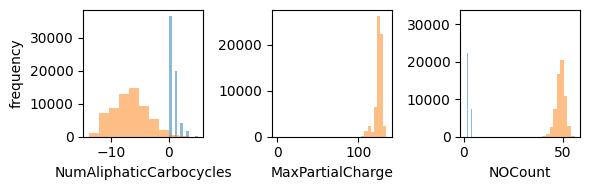

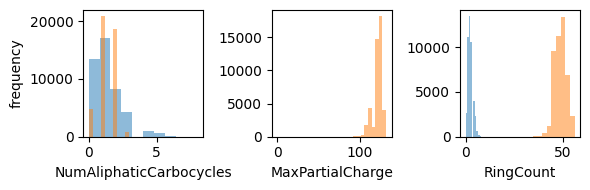

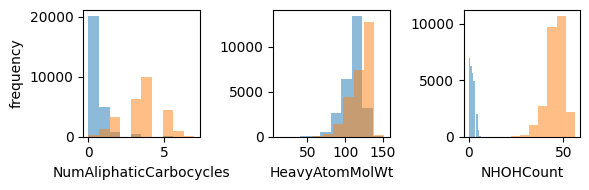

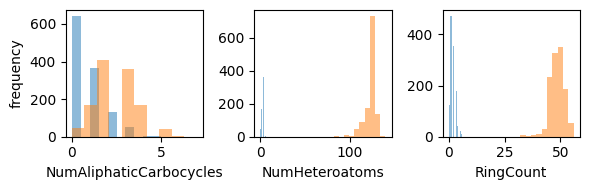

In [27]:

for i,subset in enumerate(subsets):
    df = subset.drop(labels='smiles', axis='columns', inplace=False)
    X = df.to_numpy()
    f,ax = plt.subplots(1,3,figsize=(6,2))
    for j,feature in enumerate(all_subset_variables[i]):
        ax[j].hist(df[feature].to_numpy(),alpha=0.5,label='original')
        ax[j].hist(all_intervened_X[i][:,j],alpha=0.5,label='intervened')
        ax[j].set_xlabel(feature)
    ax[0].set_ylabel('frequency')
    #ax[0].legend()
    f.tight_layout()
        

In [28]:

target_values = np.linspace(2,6,50)
interventions = []
feat = 4
for value in target_values:
    interventions.append(ce.estimate_optimal_intervention(X[5,:].reshape(1,-1), dipole_ind,
                                    regressor, feat, value)) 


## Load the active learning dataset and the searchable dataset

In [43]:
!ls ../data/processed/

GMM3_MolLogP_TPSA_MolMR       fingerprint_subset_3.npy
all_data.csv                  molecule_distances_sorted.npy
all_data_fp.npy               sample_active_df.csv
all_intervened_X_active.npy   split_class_0.csv
fingerprint_subset_1.npy      split_class_1.csv
fingerprint_subset_2.npy      split_class_2.csv


In [29]:
reference_df = pd.read_csv(os.path.join(data_path,'sousa_molecules.csv'))
active_df = pd.read_csv('sample_active_df.csv',index_col='Unnamed: 0')
all_intervened_X = np.load('all_intervened_X_active.npy')


FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/sousa_molecules.csv'

In [3]:
# make sure that we have the right columns
possible_columns = ['smiles',
 'NOCount',
 'ExactMolWt',
 'NumValenceElectrons',
 'NHOHCount',
 'NumHeteroatoms',
 'HeavyAtomMolWt',
 'RingCount',
 'MaxPartialCharge',
 'NumAliphaticCarbocycles']

# replace active DataFrame with intervened molecules. 
intervened_df = active_df.copy()
intervened_df['NumAliphaticCarbocycles'] = np.abs(all_intervened_X[:,8])

X_active = intervened_df[possible_columns].drop(labels='smiles', axis='columns', inplace=False).to_numpy()
X_active_raw = active_df[possible_columns].drop(labels='smiles', axis='columns', inplace=False).to_numpy() 
X_possible = reference_df[possible_columns].drop(labels='smiles', axis='columns', inplace=False).to_numpy()

In [4]:
# compare the chemical space of the active data set an searchable data set
reducer = PCA(n_components=None, svd_solver='full')
reducer.fit(X_active)
embedding = reducer.transform(X_active)
embedding_possible = reducer.transform(X_possible)


In [7]:
# now, I want to sort the available molecules by their dipole moments. 
columns = ['smiles',
 'NOCount',
 'ExactMolWt',
 'NumValenceElectrons',
 'NHOHCount',
 'NumHeteroatoms',
 'HeavyAtomMolWt',
 'RingCount',
 'MaxPartialCharge',
 'NumAliphaticCarbocycles',
 'dipole']

X_rf = active_df[columns].drop(labels='smiles', axis='columns', inplace=False).to_numpy() 

regr,score = mu.fit_random_forest(X_rf, False, False)

In [8]:
# dipole of the intervened molecules
dipole_intervened = regr.predict(X_active) 
inds = np.argsort(dipole_intervened) 
X_intervened_sorted = X_active[inds,:]

In [9]:
# sort the reference molecules by dipole moment
dipole = reference_df['dipole'].to_numpy()
inds = np.argsort(dipole) 
X_reference_sorted = X_possible[inds,:]

# also sort the reference data frame 
reference_df_sorted = reference_df.sort_values(by=['dipole'])
active_df_sorted = active_df.copy()
active_df_sorted['intervened_dipole'] = dipole_intervened
active_df_sorted = active_df_sorted.sort_values(by=['intervened_dipole'])


In [11]:
# find the closest molecules - slow computation. can skip to next cell
distances = np.zeros((X_intervened_sorted.shape[0],X_reference_sorted.shape[0]))
for i in range(X_intervened_sorted.shape[0]):
    for j in range(X_reference_sorted.shape[0]):
        distances[i,j] = np.sum( (X_intervened_sorted[i,:]/X_intervened_sorted.max(axis=0)
                                  - X_reference_sorted[j,:]/X_reference_sorted.max(axis=0))**2 ) 



In [15]:
# np.save('molecule_distances_sorted_sousa',distances)

NameError: name 'distances' is not defined

In [16]:
distances = np.load('molecule_distances_sorted_sousa.npy')

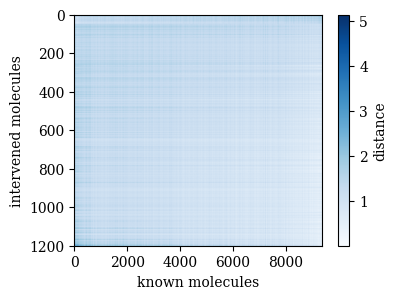

In [17]:
f,ax = plt.subplots(figsize=(4,3))
imax = ax.imshow(distances,aspect='auto',cmap='Blues')
ax.set_xlabel('known molecules')
ax.set_ylabel('intervened molecules')
f.colorbar(imax,label='distance')
# f.savefig('figures/molecule distances_sousa.svg')

In [64]:
reload(mu)
k=3
smiles_df = mu.get_top_k_close_molecules(k, distances,
                                      reference_df_sorted, active_df_sorted)


In [65]:
smiles_df

,original,closest_0,closest_1,closest_2,closest_0_dipole,closest_1_dipole,closest_2_dipole,closest_0_distance,closest_1_distance,closest_2_distance
0,OCC1C(C#N)C1C#N,C=NN=C(C)CO,O[C@]1(C(F)(F)F)NN2C=CC=CC2=NO1,OC[C@@H]1OCCc2sccc21,1.744308,5.022870,2.052224,0.055686,0.065313,0.082926
1,CCC12CC(C1)(N2)C#N,CO[C@H](C)CN,O=C(CCl)N1C(=O)N=C(O)[C@H]1O,COCCc1noc(-c2cnsn2)n1,0.578708,6.826481,1.048269,0.121366,0.122375,0.152506
2,CN=C1C=COC(C)=N1,CO[C@H](C)CN,O=C(F)[C@@]1(F)OC(F)(F)OC1(F)F,O=C(CCl)N1C(=O)N=C(O)[C@H]1O,0.578708,0.854660,6.826481,0.133538,0.187019,0.225918
3,CC1=CC2NC2C11CO1,CO[C@H](C)CN,O=C(F)[C@@]1(F)OC(F)(F)OC1(F)F,O=C(CCl)N1C(=O)N=C(O)[C@H]1O,0.578708,0.854660,6.826481,0.133362,0.186822,0.225605
4,O=CC1=NC=CC(=O)N1,CO[C@H](C)CN,C=NN=C(C)CO,OC[C@@H]1OCCc2sccc21,0.578708,1.744308,2.052224,0.058589,0.066492,0.120911
...,...,...,...,...,...,...,...,...,...,...
1196,O=CC12C=CC3C1OC23,CCN1CCCC1,C[C@@H]1CN1C,COC(=O)N1C=CC=CC=C1,0.891469,1.174334,2.019708,0.104278,0.119517,0.125644
1197,O=CC1CC2CN2C1,Fc1ccc([C@@H]2N=N[C@H](C3=CN=NC3)O2)cc1,C=C[C@H]1C[C@@H](N)C1,O=C1CN(c2ccccc2)C=NN1,3.904113,1.201145,3.387027,0.015606,0.059843,0.069808
1198,CC1CC2C3OC3C12,COC(=O)N1C=CC=CC=C1,CCN1CCCC1,NC[C@@H]1CCN1,2.019708,0.891469,2.283797,0.065459,0.109423,0.128372
1199,CC1N2CC2C11CN1,O=C1Cc2sccc2N1,C#CCON=CC,CC(=O)[C@H]1CCO1,3.041602,0.961773,1.777215,0.118149,0.141218,0.153593


In [19]:
# compare distances and tanimoto of base molecule 
min_distances = np.min(distances,axis=1)


In [66]:
# get the fingerprints for each column
reload(mu)
all_fingerprints = [mu.get_data_fingerprints(smiles_df, 'original')]
for i in range(k):
    all_fingerprints.append(mu.get_data_fingerprints(smiles_df,f"closest_{i}"))

In [67]:
reload(mu)
all_similarities = []
for i in range(k):
    all_similarities.append(mu.get_tanimoto_similarities(all_fingerprints[0], all_fingerprints[i+1]))
similarities = np.array(all_similarities).T

In [68]:
# find the molecules that are most similar 
sorted_similarity = smiles_df.copy()
mean_similarity = np.mean(similarities,axis=1)
for i,similarity in enumerate(similarities.T):
    sorted_similarity[f'similarity_{i}'] = similarity
sorted_similarity['mean_similarity'] = mean_similarity 
sorted_similarity.sort_values(by=['similarity_0'],ascending=False, inplace=True)

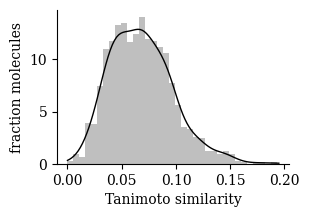

In [69]:
f,ax = plt.subplots(figsize=(3,2))
kde = KernelDensity(kernel='gaussian', bandwidth=0.008).fit(mean_similarity.reshape(-1,1))
xplot = np.linspace( np.min(mean_similarity)*.9, np.max(mean_similarity)*1.01, 100).reshape(-1,1)
ax.plot(xplot, np.exp(kde.score_samples(xplot)),color='k',linewidth=1)
_ = ax.hist(mean_similarity, bins=35, density=True,alpha=.5,facecolor='gray')
ax.spines[['right', 'top']].set_visible(False)

ax.set_xlabel('Tanimoto similarity')
ax.set_ylabel('fraction molecules') 
f.savefig('figures/tanimoto_similarity.svg')


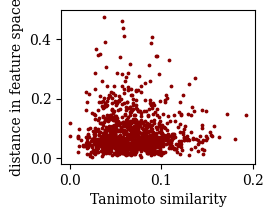

In [24]:
f,ax = plt.subplots(figsize=(2.5,2))
ax.scatter(mean_similarity,min_distances,s=3,c='darkred')
ax.set_xlabel('Tanimoto similarity')
ax.set_ylabel('distance in feature space')
f.savefig('figures/reference_feature_scatter.svg') 

In [70]:
# see how much the molecules move in chemical space 
sorted_index = np.array(sorted_similarity.index)

# get the chemcical space of the active dataframe
active_fp = np.array(mu.get_data_fingerprints(active_df, 'smiles'))
reducer = PCA(n_components=None, svd_solver='full')
reducer.fit(active_fp)
embedding = reducer.transform(active_fp)

before = reducer.transform(np.array(all_fingerprints[0])[sorted_index])
after = reducer.transform(np.array(all_fingerprints[1])[sorted_index]) 

dipoles 0: 2.7531 , 0.077471
dipoles 1: 2.2999 , 1.777215
dipoles 2: 1.4402 , 0.077471
dipoles 3: 0.8254 , 2.441781
dipoles 4: 1.767 , 2.749288
dipoles 5: 3.3629 , 1.687856
dipoles 6: 2.4972 , 0.077471
dipoles 7: 1.6848 , 5.07004
dipoles 8: 3.325 , 0.961773
dipoles 9: 0.2279 , 0.077471


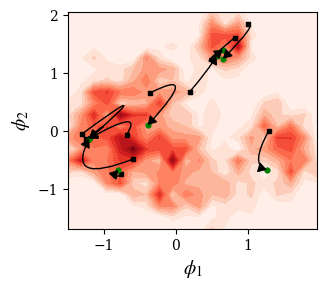

In [71]:
reload(mu)
f,ax = plt.subplots(1,1,figsize=(3.5,3))
binsxa,binsya,hist_active = mu.getcolordensity_contour(embedding[:,0], embedding[:,1])
start,stop = 10,20

ax.contourf(binsxa, binsya, hist_active, cmap='Reds', levels=15)
ax.scatter(before[start:stop,0], before[start:stop,1],c='k',s=12, marker='s')
ax.scatter(after[start:stop,0], after[start:stop,1],c='g',s=12)
nplot = stop-start
for i in range(start,stop):
    ax = mu.plot_path_between(before[i,:2], after[i,:2], ax)
    
ax.set_xlabel(r'$\phi_1$',fontsize=14)
ax.set_ylabel(r'$\phi_2$',fontsize=14)
f.tight_layout()
# f.savefig('figures/intervened_molecules.pdf')

# draw the molecules
for i in range(nplot): 
    mu.draw_molecules([sorted_similarity['original'].to_list()[i], 
                       sorted_similarity['closest_0'].to_list()[i]],
                   prefix=f'./figures/dipole_intervene/molecule_{i}')
    dipole_og = merged_df['dipole'][i]
    dipole_closest = merged_df['closest_0_dipole'][i]
    print(f'dipoles {i}: {dipole_og} , {dipole_closest}')
    

In [72]:
# predict the intervened molecule's dipole using rf:
columns = ['smiles',
 'NOCount',
 'ExactMolWt',
 'NumValenceElectrons',
 'NHOHCount',
 'NumHeteroatoms',
 'HeavyAtomMolWt',
 'RingCount',
 'MaxPartialCharge',
 'NumAliphaticCarbocycles',
 'dipole']

X_rf = active_df[columns].drop(labels='smiles', axis='columns', inplace=False).to_numpy() 

regr,score = mu.fit_random_forest(X_rf, False, False)

In [73]:
# predict the dipole in the intervened molecule
intervened_X = intervened_df[columns].drop(labels=['smiles','dipole'], axis='columns', inplace=False).to_numpy()
intervened_df['dipole_pred'] = regr.predict(intervened_X)

In [74]:
# do a data join on smiles
merged_df = sorted_similarity.merge(intervened_df,left_on='original',right_on='smiles')


In [77]:
merged_df['delta_dipole'] = merged_df['dipole_pred'] - merged_df['dipole']

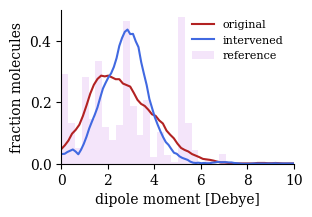

In [80]:

colors = ['firebrick','royalblue','darkviolet']
f,ax = plt.subplots(figsize=(3,2))
kde = KernelDensity(kernel='tophat', bandwidth=.5).fit(merged_df['dipole'].to_numpy().reshape(-1,1))
xplot = np.linspace( np.min(merged_df['dipole'].to_numpy()), np.max(merged_df['dipole'].to_numpy()), 100).reshape(-1,1)
ax.plot(xplot, np.exp(kde.score_samples(xplot)),color=colors[0],label='original')

kde = KernelDensity(kernel='tophat', bandwidth=.5).fit(merged_df['dipole_pred'].to_numpy().reshape(-1,1))
xplot = np.linspace( np.min(merged_df['dipole_pred'].to_numpy()), np.max(merged_df['dipole_pred'].to_numpy()), 100).reshape(-1,1)
ax.plot(xplot, np.exp(kde.score_samples(xplot)),color=colors[1],label='intervened')

kde = KernelDensity(kernel='tophat', bandwidth=.2).fit(merged_df['closest_0_dipole'].to_numpy().reshape(-1,1))
xplot = np.linspace( np.min(merged_df['closest_0_dipole'].to_numpy()), np.max(merged_df['closest_0_dipole'].to_numpy()), 100).reshape(-1,1)
#ax.plot(xplot, np.exp(kde.score_samples(xplot)),color=colors[2])


#_ = ax.hist(merged_df['dipole'].to_numpy(), bins=35, density=True,alpha=.1,color=colors[0])
#_ = ax.hist(merged_df['dipole_pred'].to_numpy(), bins=35, density=True,alpha=.1,color=colors[1])
_ = ax.hist(merged_df['closest_0_dipole'].to_numpy(), bins=35, density=True,alpha=.1,color=colors[2],label='reference')
ax.spines[['right', 'top']].set_visible(False)
ax.legend(frameon=False,fontsize=8)
ax.set_xlabel('dipole moment [Debye]')
ax.set_ylabel('fraction molecules') 
ax.set_xlim([0,10])
f.savefig('figures/original_intervened_dipole_histogram.svg') 